In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

Speeds_to_initial_ISI = {
    '1': 3.0,  
    '2': 2.5,
    '3': 2.0,
    '4': 1.5,
    '5': 1.0  
}

def plot_reaction_time_over_trials(test_csv_path):
    """
    Plot reaction time over trials using rolling windows of 10 trials.

    Args:
        test_csv_path (str): Path to the specific test CSV file.
    """
    # Check if file exists
    if not os.path.isfile(test_csv_path):
        print(f"File not found: {test_csv_path}")
        return

    # Read CSV
    df = pd.read_csv(test_csv_path)

    # Ensure 'RT' is numeric, handle missing values
    df['RT'] = pd.to_numeric(df['RT'], errors='coerce')

    # Calculate rolling average with window=10
    df['RT_Rolling'] = df['RT'].rolling(window=10, min_periods=1).mean()

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='TrialIndex', y='RT_Rolling', data=df, label='Rolling Avg RT (10 trials)')
    plt.xlabel('Trial Index')
    plt.ylabel('Reaction Time (s)')
    plt.title('Reaction Time Over Trials (Rolling Avg of 10 Trials)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_reaction_time_across_speeds(test_csv_path):
    """
    Plot average reaction time across different speeds (ISI levels).

    Args:
        test_csv_path (str): Path to the specific test CSV file.
    """
    # Check if file exists
    if not os.path.isfile(test_csv_path):
        print(f"File not found: {test_csv_path}")
        return

    # Read CSV
    df = pd.read_csv(test_csv_path)

    # Ensure 'RT' and 'ISI' are numeric
    df['RT'] = pd.to_numeric(df['RT'], errors='coerce')
    df['ISI'] = pd.to_numeric(df['ISI'], errors='coerce')

    # Define ISI to Speed mapping
    ISI_to_speed = {3.0: 1, 2.5: 2, 2.0: 3, 1.5: 4, 1.0: 5}

    # Map 'ISI' to 'Speed' levels
    df['Speed'] = df['ISI'].map(ISI_to_speed)

    # Handle any unmapped ISI values
    df['Speed'] = df['Speed'].fillna(0).astype(int)

    # Calculate average RT per Speed
    avg_rt = df.groupby('Speed')['RT'].mean().reset_index()

    # Sort by Speed
    avg_rt = avg_rt.sort_values('Speed')

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Speed', y='RT', data=avg_rt, palette='viridis')
    plt.xlabel('Speed Level')
    plt.ylabel('Average Reaction Time (s)')
    plt.title('Average Reaction Time Across Speed Levels')
    plt.ylim(0, df['RT'].max() + 0.5)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

def participant_overall_stats(participant_dir):
    """
    Provide overall statistics for a participant.

    Stats include:
        - Highest n-back level reached
        - Average accuracy
        - Average reaction time
        - Average speed level
        - Average n-back level across all tests

    Args:
        participant_dir (str): Path to the participant's directory containing CSV files.

    Returns:
        dict: Dictionary containing the overall statistics.
    """
    # Check if directory exists
    if not os.path.isdir(participant_dir):
        print(f"Directory not found: {participant_dir}")
        return None

    # Get all CSV files in the participant's directory
    csv_files = glob.glob(os.path.join(participant_dir, "*.csv"))

    if not csv_files:
        print(f"No CSV files found in {participant_dir}.")
        return None

    # Initialize lists
    nback_levels = []
    accuracies = []
    reaction_times = []
    speed_levels = []

    # Loop through CSV files
    for file in csv_files:
        df = pd.read_csv(file)

        # Highest n-back in this session
        max_nback = df['N-back'].max()
        nback_levels.append(max_nback)

        # Average accuracy in this session
        avg_accuracy = df['Correct'].mean()
        accuracies.append(avg_accuracy)

        # Average reaction time, excluding NaNs
        avg_rt = pd.to_numeric(df['RT'], errors='coerce').mean()
        reaction_times.append(avg_rt)

        # Average speed level: map 'Initial_ISI' to speed level
        # Assuming 'Initial_ISI' corresponds to speed_level, as per mapping
        initial_ISI = df['Initial_ISI'].iloc[0]
        speed_level = Speeds_to_initial_ISI.get(initial_ISI, 0)  # Default to 0 if not found
        speed_levels.append(speed_level)

    # Overall stats
    overall_highest_nback = max(nback_levels)
    overall_avg_accuracy = (sum(accuracies) / len(accuracies)) * 100  # as percentage
    overall_avg_rt = sum(reaction_times) / len(reaction_times)
    overall_avg_speed = sum(speed_levels) / len(speed_levels)
    overall_avg_nback = sum(nback_levels) / len(nback_levels)

    # Compile stats
    stats = {
        'Highest N-back Level': overall_highest_nback,
        'Average Accuracy (%)': round(overall_avg_accuracy, 2),
        'Average Reaction Time (s)': round(overall_avg_rt, 3),
        'Average Speed Level': round(overall_avg_speed, 2),
        'Average N-back Level': round(overall_avg_nback, 2)
    }

    # Display stats
    print(f"Overall Stats for Participant '{participant_dir}':")
    for key, value in stats.items():
        print(f"{key}: {value}")

    return stats

def participant_performance_dataframe(participant_dir):
    """
    Provide a dataframe showing accuracy, reaction time, and sessions by n-back level for a participant.

    Args:
        participant_dir (str): Path to the participant's directory containing CSV files.

    Returns:
        pd.DataFrame: Dataframe with columns ['Session', 'N-back', 'Accuracy (%)', 'Average_RT (s)'].
    """
    # Check if directory exists
    if not os.path.isdir(participant_dir):
        print(f"Directory not found: {participant_dir}")
        return None

    # Get all CSV files in the participant's directory
    csv_files = glob.glob(os.path.join(participant_dir, "*.csv"))

    if not csv_files:
        print(f"No CSV files found in {participant_dir}.")
        return None

    # Initialize list
    data = []

    # Loop through CSV files
    for file in csv_files:
        df = pd.read_csv(file)

        # Extract Session ID from filename (assuming format: data_{participant_id}_{session_id}_{timestamp}.csv)
        filename = os.path.basename(file)
        try:
            parts = filename.split('_')
            session_id = parts[2]  # 'session1' etc.
        except IndexError:
            session_id = 'Unknown'

        # N-back level for this session
        nback_level = df['N-back'].iloc[0]

        # Accuracy
        accuracy = df['Correct'].mean() * 100  # as percentage

        # Average RT
        avg_rt = pd.to_numeric(df['RT'], errors='coerce').mean()

        # Append to data list
        data.append({
            'Session': session_id,
            'N-back': nback_level,
            'Accuracy (%)': round(accuracy, 2),
            'Average_RT (s)': round(avg_rt, 3)
        })

    # Create dataframe
    performance_df = pd.DataFrame(data)

    # Sort by Session (assuming session IDs are sortable)
    performance_df = performance_df.sort_values('Session')

    # Display dataframe
    print(f"Performance Dataframe for Participant '{participant_dir}':")
    print(performance_df)

    return performance_df

def plot_average_rt_vs_nback(data_dir):
    """
    Plot average reaction time vs average n-back level across all participants.

    Args:
        data_dir (str): Path to the main data directory containing participant subdirectories.
    """
    # Initialize lists
    participants = []
    avg_rts = []
    avg_nbacks = []

    # Get all participant directories
    participant_dirs = [d for d in glob.glob(os.path.join(data_dir, "*")) if os.path.isdir(d)]

    if not participant_dirs:
        print(f"No participant directories found in {data_dir}.")
        return

    # Loop through participant directories
    for p_dir in participant_dirs:
        participant_id = os.path.basename(p_dir)
        csv_files = glob.glob(os.path.join(p_dir, "*.csv"))

        if not csv_files:
            continue  # Skip participants with no data

        # Initialize lists for this participant
        p_avg_rt = []
        p_avg_nback = []

        # Loop through CSV files
        for file in csv_files:
            df = pd.read_csv(file)

            # Average RT
            avg_rt = pd.to_numeric(df['RT'], errors='coerce').mean()
            p_avg_rt.append(avg_rt)

            # N-back level
            nback = df['N-back'].mean()
            p_avg_nback.append(nback)

        # Calculate overall average RT and n-back for the participant
        overall_avg_rt = sum(p_avg_rt) / len(p_avg_rt) if p_avg_rt else 0
        overall_avg_nback = sum(p_avg_nback) / len(p_avg_nback) if p_avg_nback else 0

        # Append to lists
        participants.append(participant_id)
        avg_rts.append(overall_avg_rt)
        avg_nbacks.append(overall_avg_nback)

    # Create dataframe
    summary_df = pd.DataFrame({
        'Participant': participants,
        'Average_RT (s)': avg_rts,
        'Average_N-back': avg_nbacks
    })

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Average_N-back', y='Average_RT (s)', data=summary_df, hue='Participant', s=100, palette='deep')
    plt.xlabel('Average N-back Level')
    plt.ylabel('Average Reaction Time (s)')
    plt.title('Average Reaction Time vs Average N-back Level Across Participants')
    plt.grid(True)
    plt.legend(title='Participant', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



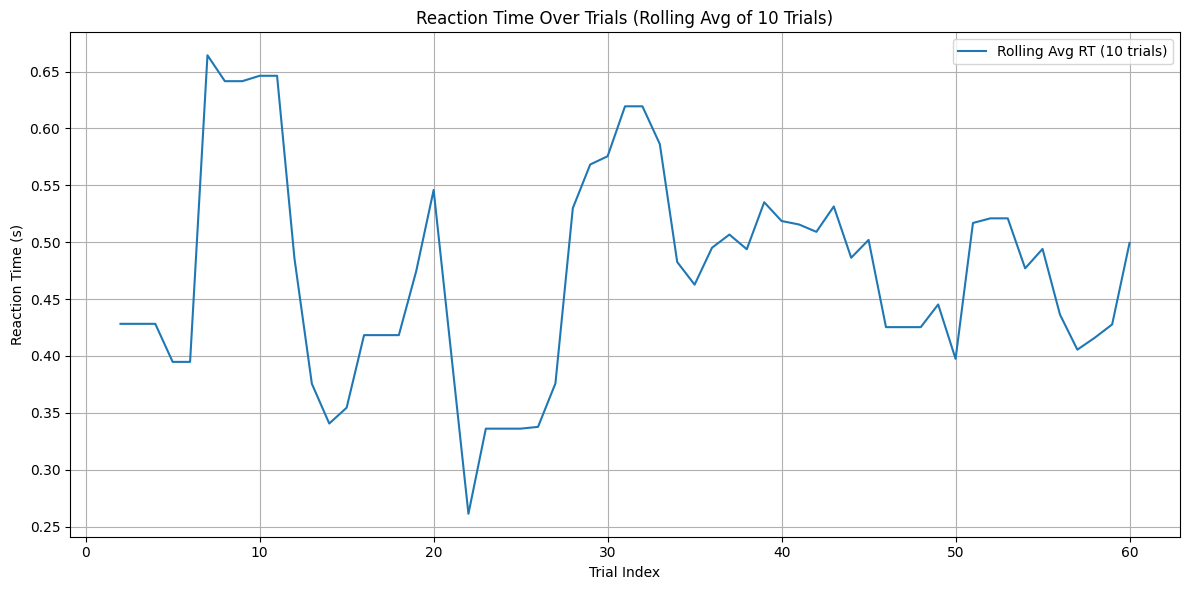

In [5]:
plot_reaction_time_over_trials("C:/Users/tue.vu_pison/Desktop/git/dataops_tools/pison_nback/data/tue/data_tue_1_nback2_speed5_2025-01-30_16-01-51.csv")